Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
                                        Product Name  Price   \
0                 Core Power Elite Shake (Chocolate)    3.99   
1                Quest Protein Bar (Cookies & Cream)    2.59   
2                    Premier Protein Shake (Vanilla)    3.49   
3                         RXBAR (Chocolate Sea Salt)    2.79   
4  Optimum Nutrition Gold Standard Shake (Strawbe...    4.19   

                     Product Label Image Description  Rate (out of 5)    Sale  \
0  Black bottle with a gold lightning bolt graphi...              4.6   98500   
1  White wrapper with blue text and a picture of ...              4.4  125000   
2      Silver carton with green and purple swooshes.              4.7  155000   
3  Minimalist brown wrapper listing

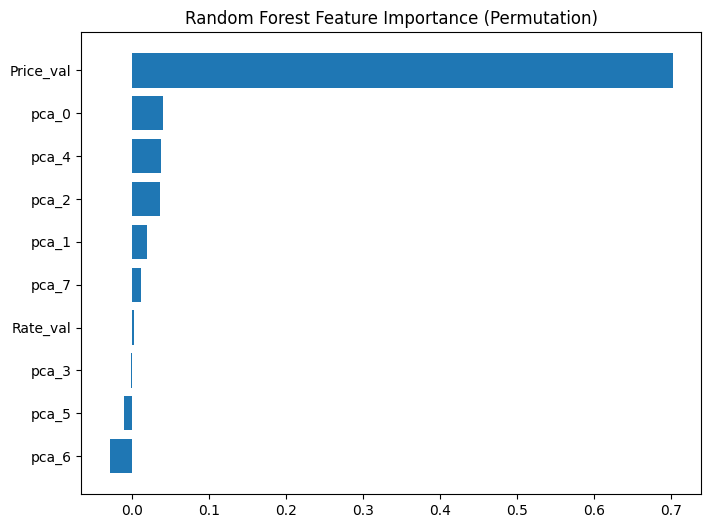

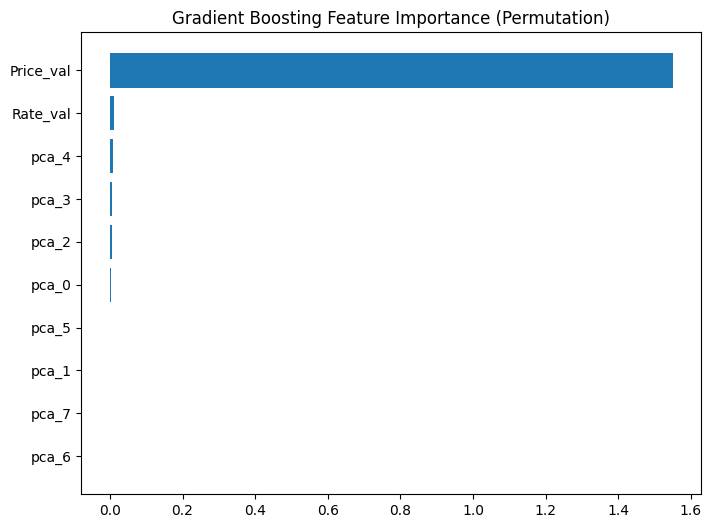

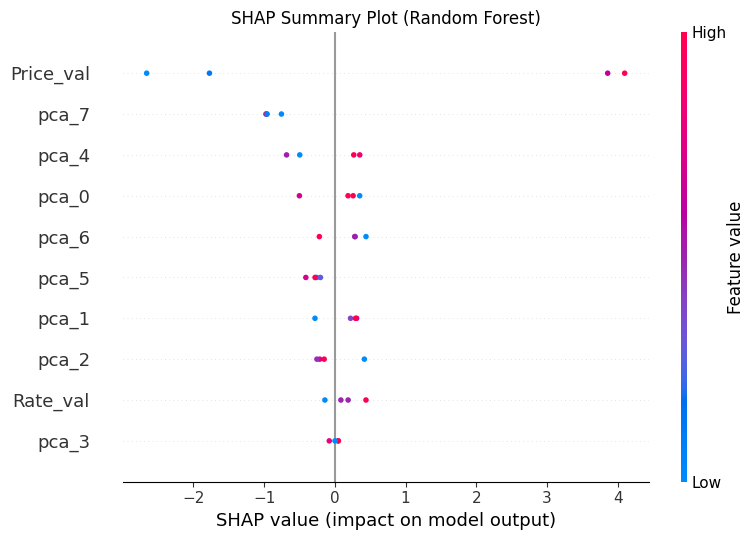

In [27]:
# Image-Based ML Pipeline Notebook (Python Script Styled Like Jupyter Cells)
# ---------------------------------------------------------------
# This file contains tidy, notebook-style sections.
# You can copy each section into Jupyter Notebook cells.

# %pip install openpyxl
%pip install tensorflow.keras

### 1. Imports and Setup
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import joblib

# TensorFlow for CNN embeddings
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Optional SHAP
try:
    import shap
    USE_SHAP = True
except:
    USE_SHAP = False

# Paths
PROJECT_DIR = Path("/Users/mohini.gangaram/Desktop/ML PostGrad/Sem 3/Main Project")
EXCEL_PATH = PROJECT_DIR / "Protein Products.xlsx"
IMAGES_DIR = PROJECT_DIR / "Protein Product Images"
OUTPUT_DIR = PROJECT_DIR / "ml_outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 3
PCA_MAX_COMPONENTS = 8


### 2. Load and Inspect Data

# Load Excel
products_df = pd.read_excel(EXCEL_PATH)
print(products_df.head())

# List images in order
img_files = sorted([p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in ['.jpg', '.png', '.jpeg'] ], key=lambda x: int(x.stem))

print("Total images found:", len(img_files))
print("Total rows in file:", products_df.shape[0])

n_use = min(len(img_files), products_df.shape[0])
print(f"Using first {n_use} images and first {n_use} rows.")


### 3. Build CNN Model for Embeddings

# Simple custom CNN extractor instead of MobileNetV2
from tensorflow.keras import layers, models


simple_cnn = models.Sequential([
layers.Rescaling(1./255, input_shape=(160,160,3)),
layers.Conv2D(16, (3,3), activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, (3,3), activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, (3,3), activation='relu'),
layers.GlobalAveragePooling2D(),
layers.Dense(128, activation='linear')
])


simple_cnn.trainable = False
model = simple_cnn
print("Embedding size:", 128)


### 4. Extract Embeddings

def extract_embedding(path):
    img = Image.open(path).convert('RGB').resize((224,224))
    arr = np.array(img).astype('float32')
    arr = preprocess_input(np.expand_dims(arr,0))
    emb = model.predict(arr, verbose=0)[0]
    return emb

embeddings = []
for i in range(n_use):
    emb = extract_embedding(img_files[i])
    embeddings.append(emb)

ebm = np.vstack(embeddings)
print("Embeddings shape:", ebm.shape)


### 5. Merge Data and Create Target

merge_df = products_df.iloc[:n_use].copy().reset_index(drop=True)
print(merge_df.columns)

# Identify numeric columns
sale_col = 'Sales Number (Units/Year)'
price_col = 'Price '
rate_col = 'Rate (out of 5)'

merge_df['Sale_val'] = merge_df['Sale']
merge_df['Price_val'] = merge_df[price_col]
merge_df['Rate_val'] = pd.to_numeric(merge_df[rate_col], errors='coerce').fillna(0)

merge_df['Sales_Success'] = np.log1p(merge_df['Sale_val']) * merge_df['Price_val'] + np.log1p(merge_df['Rate_val'])

emb_cols = [f"emb_{i}" for i in range(ebm.shape[1])]
emb_df = pd.DataFrame(ebm, columns=emb_cols)

full_df = pd.concat([merge_df, emb_df], axis=1)
full_df.to_csv(OUTPUT_DIR / "merged_embeddings.csv", index=False)
full_df.head()


### 6. PCA on Embeddings

X_emb = emb_df.values
scaler = StandardScaler()
X_emb_s = scaler.fit_transform(X_emb)

n_comp = min(PCA_MAX_COMPONENTS, n_use-1)
pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_emb_s)

pca_cols = [f"pca_{i}" for i in range(n_comp)]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)

model_df = pd.concat([merge_df[['Price_val','Rate_val']].reset_index(drop=True), pca_df], axis=1)
y = merge_df['Sales_Success']


### 7. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(model_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


### 8. Random Forest Model + Tuning

rf_grid = {
    'n_estimators': [100],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt']
}

cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
rf = RandomForestRegressor(random_state=RANDOM_STATE)

gs_rf = GridSearchCV(rf, rf_grid, cv=cv, scoring='r2')
gs_rf.fit(X_train, y_train)

best_rf = gs_rf.best_estimator_
print("Best RF Params:", gs_rf.best_params_)

rf_pred = best_rf.predict(X_test)
print("RF R2:", r2_score(y_test, rf_pred))
print("RF RMSE:", mean_squared_error(y_test, rf_pred))


### 9. Gradient Boosting + Tuning

gb_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3,5]
}

gb = GradientBoostingRegressor(random_state=RANDOM_STATE)
gs_gb = GridSearchCV(gb, gb_grid, cv=cv, scoring='r2')
gs_gb.fit(X_train, y_train)

best_gb = gs_gb.best_estimator_
print("Best GB Params:", gs_gb.best_params_)

gb_pred = best_gb.predict(X_test)
print("GB R2:", r2_score(y_test, gb_pred))
print("GB RMSE:", mean_squared_error(y_test, gb_pred))


### 10. Permutation Importance (Plots)

rf_imp = permutation_importance(best_rf, X_test, y_test, n_repeats=20, random_state=42)
rf_imp_df = pd.DataFrame({
    'feature': model_df.columns,
    'importance': rf_imp.importances_mean
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
plt.barh(rf_imp_df['feature'], rf_imp_df['importance'])
plt.title("Random Forest Feature Importance (Permutation)")
plt.gca().invert_yaxis()
plt.show()


gb_imp = permutation_importance(best_gb, X_test, y_test, n_repeats=20, random_state=42)
gb_imp_df = pd.DataFrame({
    'feature': model_df.columns,
    'importance': gb_imp.importances_mean
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
plt.barh(gb_imp_df['feature'], gb_imp_df['importance'])
plt.title("Gradient Boosting Feature Importance (Permutation)")
plt.gca().invert_yaxis()
plt.show()


### 11. SHAP Plots (If Available)

if USE_SHAP:
    explainer = shap.Explainer(best_rf, X_train)
    shap_vals = explainer(X_test)

    plt.title("SHAP Summary Plot (Random Forest)")
    shap.summary_plot(shap_vals, X_test, feature_names=model_df.columns)
else:
    print("SHAP not installed, skipping plots.")
